# Learning Rate Range Test on CIFAR-10 with fastai

This notebook uses the [fastai](https://github.com/fastai/fastai) library. 

It is meant to reproduce the learning rate range test that fastai published [in this notebook](https://github.com/sgugger/Deep-Learning/blob/master/Cyclical%20LR%20and%20momentums.ipynb) and presented in [this blog post](https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6). 

As the linked notebook is based on an old version of fastai, we modify the code to comply with the latest version of the library.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

Set seeds for reproducibility

In [2]:
import torch
import numpy as np
import random as rn

np.random.seed(42) # cpu vars
rn.seed(12345) # Python

torch.manual_seed(1234) # cpu  vars
torch.cuda.manual_seed(1234)
torch.cuda.manual_seed_all(1234) # gpu vars
torch.backends.cudnn.deterministic = True  #needed
torch.backends.cudnn.benchmark = False

## fastai reference result

The tests are run on cifar 10 with an SGD optimizer finding the result in the following picture and selecting a final range of 0.08 - 0.8 (to 3).

In [3]:
from IPython.display import Image
Image(url="https://miro.medium.com/max/346/1*aSQd2ZN4Kl3DXPJzw3kTpQ.jpeg", width=600, height=300)

## LRRT tests

In [4]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [5]:
from fastai.vision import *

In [6]:
path = untar_data(URLs.CIFAR)

Data augmentation: random horizontal flip and reflection padding of 4 pixels.

In [7]:
ds_tfms = ([*rand_pad(4, 32), flip_lr(p=0.5)], [])
data = ImageDataBunch.from_folder(path, valid='test', ds_tfms=ds_tfms, bs=512).normalize(cifar_stats)

horse


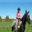

In [8]:
img,label = data.train_ds[0]
print(label)
img

In [9]:
img.shape

torch.Size([3, 32, 32])

### Resnet-56 model

Basic bloc of the resnet version for cifar10 (no bottlenecks).

In [10]:
class BasicBlock(nn.Module):
    
    def __init__(self, ch_in, ch_out, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=stride, padding=1, bias=False)
        torch.nn.init.kaiming_uniform(self.conv1.weight, a=0, nonlinearity='relu')
        self.bn1 = nn.BatchNorm2d(ch_out)
        
        self.conv2 = nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=False)
        torch.nn.init.kaiming_uniform(self.conv2.weight, a=0, nonlinearity='relu')
        self.bn2 = nn.BatchNorm2d(ch_out)

        if stride != 1 or ch_in != ch_out:
            self.shortcut = nn.Sequential(
                nn.Conv2d(ch_in, ch_out, kernel_size=1, stride=stride, bias=False)#,
                #nn.BatchNorm2d(ch_out)
                # removing this additional BN layer to have the very same model as in
                # https://keras.io/examples/cifar10_resnet/
            )
            torch.nn.init.kaiming_uniform(self.shortcut[0].weight, a=0, nonlinearity='relu')

    def forward(self, x):
        shortcut = self.shortcut(x) if hasattr(self, 'shortcut') else x
        out = self.conv1(x)
        out = self.bn2(self.conv2(F.relu(self.bn1(out))))
        out += shortcut
        return F.relu(out)

Resnet for cifar10 with 56 convolutional layers.

We override the default fastai initialization and use the same as in the keras implementation: ```kaiming_uniform```:

```
torch.nn.init.kaiming_uniform(self.conv1.weight, a=0, nonlinearity='relu')
```

In [11]:
class ResNet(nn.Module):
    def __init__(self, num_blocks, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        torch.nn.init.kaiming_uniform(self.conv1.weight, a=0, nonlinearity='relu')
        self.bn1 = nn.BatchNorm2d(16)
        
        self.layer1 = self.make_group_layer(16, 16, num_blocks[0], stride=1)
        self.layer2 = self.make_group_layer(16, 32, num_blocks[1], stride=2)
        self.layer3 = self.make_group_layer(32, 64, num_blocks[2], stride=2)
        
        self.linear = nn.Linear(64, num_classes)
        torch.nn.init.kaiming_uniform(self.linear.weight, a=0, nonlinearity='relu')

    def make_group_layer(self,ch_in, ch_out, num_blocks, stride):
        layers = [BasicBlock(ch_in, ch_out, stride)]
        for i in range(num_blocks-1):
            layers.append(BasicBlock(ch_out, ch_out, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        return F.log_softmax(self.linear(out))

### SGD Optimizer

The default optimizer is Adam. We switch to SGD.

In [12]:
my_optim = functools.partial(torch.optim.SGD, lr=0.01, momentum=0.9)

In [15]:
learn = Learner(data, ResNet([9,9,9]), metrics=accuracy, opt_func=my_optim).to_fp32()
learn.crit = F.nll_loss

/data/home/smaggio/workspace/env_fastai/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  """
/data/home/smaggio/workspace/env_fastai/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  
/data/home/smaggio/workspace/env_fastai/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  # Remove the CWD from sys.path while we load stuff.
/data/home/smaggio/workspace/env_fastai/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/data/home/smaggio/workspace/env_fastai/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  de

In [14]:
learn.opt_func

functools.partial(<class 'torch.optim.sgd.SGD'>, lr=0.01, momentum=0.9)

In [16]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [17]:
learn.summary()

/data/home/smaggio/workspace/env_fastai/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


ResNet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 32, 32]         432        True      
______________________________________________________________________
BatchNorm2d          [16, 32, 32]         32         True      
______________________________________________________________________
Conv2d               [16, 32, 32]         2,304      True      
______________________________________________________________________
BatchNorm2d          [16, 32, 32]         32         True      
______________________________________________________________________
Conv2d               [16, 32, 32]         2,304      True      
______________________________________________________________________
BatchNorm2d          [16, 32, 32]         32         True      
______________________________________________________________________
Conv2d               [16, 32, 32]         2,304      True      
_______________________________________________________

### Single run of the Learning Rate Finder

In [17]:
learn.lr_find(wd=1e-4, end_lr=100)

epoch,train_loss,valid_loss,accuracy,time


/data/home/smaggio/workspace/env_fastai/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.90E-04
Min loss divided by 10: 2.40E-01


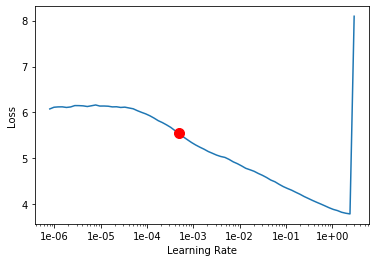

In [18]:
learn.recorder.plot(suggestion=True)

### Compute averages on multiple runs of LRRT

In [18]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
import os

from lr_finder_tools.visualization import plot_lr_loss, plot_lrrt_curves_by_max_lr, stack_tests

In [19]:
def multiple_runs_lr_find(n, learn=False, filepath='./lr_find_data.pkl'):
    suggested_lrs = []
    max_lrs = []
    losses = []
    
    input_learn = learn
    
    for i in range(n):
        if not input_learn:
            learn = Learner(data, ResNet([9,9,9]), metrics=accuracy, opt_func=my_optim).to_fp32()
            learn.crit = F.nll_loss
            
        learn.lr_find(wd=1e-4, end_lr=100)
        learn.recorder.plot(suggestion=True)
        
        losses.append(learn.recorder.losses)
        suggested_lrs.append(learn.recorder.min_grad_lr)
        min_loss_idx = np.argmin(learn.recorder.losses)
        max_lrs.append(learn.recorder.lrs[min_loss_idx]/10)
        
        plt.close()
        
    lrs = 1e-7*(100/1e-7)**np.linspace(0, 1, num=100)
    
    lrs_res, all_losses_res, all_min_lr_res, all_max_lr_res = stack_tests(lrs, losses, suggested_lrs, max_lrs)
    
    with open(filepath, 'wb') as fp:
        pickle.dump([lrs_res, all_losses_res, all_min_lr_res, all_max_lr_res], fp)
        
    return lrs_res, all_losses_res, all_min_lr_res, all_max_lr_res

In [20]:
NUM_EXPERIMENTS = 20

### Multiple runs with same weight initialization and random batch sampling

In [21]:
lrs_res, all_losses_res, all_min_lr_res, all_max_lr_res = multiple_runs_lr_find(
    n = NUM_EXPERIMENTS, 
    learn = learn, 
    filepath = './lr_find_data_reset_weight.pkl'
)

epoch,train_loss,valid_loss,accuracy,time


/data/home/smaggio/workspace/env_fastai/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.90E-04
Min loss divided by 10: 1.95E-01


epoch,train_loss,valid_loss,accuracy,time


/data/home/smaggio/workspace/env_fastai/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.03E-04
Min loss divided by 10: 2.45E-02


epoch,train_loss,valid_loss,accuracy,time


/data/home/smaggio/workspace/env_fastai/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.41E-04
Min loss divided by 10: 5.62E-02


epoch,train_loss,valid_loss,accuracy,time


/data/home/smaggio/workspace/env_fastai/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.03E-04
Min loss divided by 10: 1.58E-01


epoch,train_loss,valid_loss,accuracy,time


/data/home/smaggio/workspace/env_fastai/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.90E-04
Min loss divided by 10: 1.05E-01


epoch,train_loss,valid_loss,accuracy,time


/data/home/smaggio/workspace/env_fastai/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.90E-04
Min loss divided by 10: 4.57E-02


epoch,train_loss,valid_loss,accuracy,time


/data/home/smaggio/workspace/env_fastai/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.03E-04
Min loss divided by 10: 1.05E-01


epoch,train_loss,valid_loss,accuracy,time


/data/home/smaggio/workspace/env_fastai/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-04
Min loss divided by 10: 1.95E-01


epoch,train_loss,valid_loss,accuracy,time


/data/home/smaggio/workspace/env_fastai/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.90E-04
Min loss divided by 10: 3.72E-02


epoch,train_loss,valid_loss,accuracy,time


/data/home/smaggio/workspace/env_fastai/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.03E-04
Min loss divided by 10: 4.57E-02


epoch,train_loss,valid_loss,accuracy,time


/data/home/smaggio/workspace/env_fastai/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.03E-04
Min loss divided by 10: 2.95E-01


epoch,train_loss,valid_loss,accuracy,time


/data/home/smaggio/workspace/env_fastai/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.03E-04
Min loss divided by 10: 6.92E-02


epoch,train_loss,valid_loss,accuracy,time


/data/home/smaggio/workspace/env_fastai/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.03E-04
Min loss divided by 10: 1.05E-01


epoch,train_loss,valid_loss,accuracy,time


/data/home/smaggio/workspace/env_fastai/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.03E-04
Min loss divided by 10: 1.58E-01


epoch,train_loss,valid_loss,accuracy,time


/data/home/smaggio/workspace/env_fastai/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.03E-04
Min loss divided by 10: 1.95E-01


epoch,train_loss,valid_loss,accuracy,time


/data/home/smaggio/workspace/env_fastai/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.03E-04
Min loss divided by 10: 8.51E-02


epoch,train_loss,valid_loss,accuracy,time


/data/home/smaggio/workspace/env_fastai/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.03E-04
Min loss divided by 10: 4.57E-02


epoch,train_loss,valid_loss,accuracy,time


/data/home/smaggio/workspace/env_fastai/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.03E-04
Min loss divided by 10: 5.62E-02


epoch,train_loss,valid_loss,accuracy,time


/data/home/smaggio/workspace/env_fastai/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.90E-04
Min loss divided by 10: 5.50E-01


epoch,train_loss,valid_loss,accuracy,time


/data/home/smaggio/workspace/env_fastai/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.03E-04
Min loss divided by 10: 2.95E-01


In [22]:
with open('./lr_find_data_reset_weight.pkl', 'rb') as fp:
        lrs_res, all_losses_res, all_min_lr_res, all_max_lr_res = pickle.load(fp)

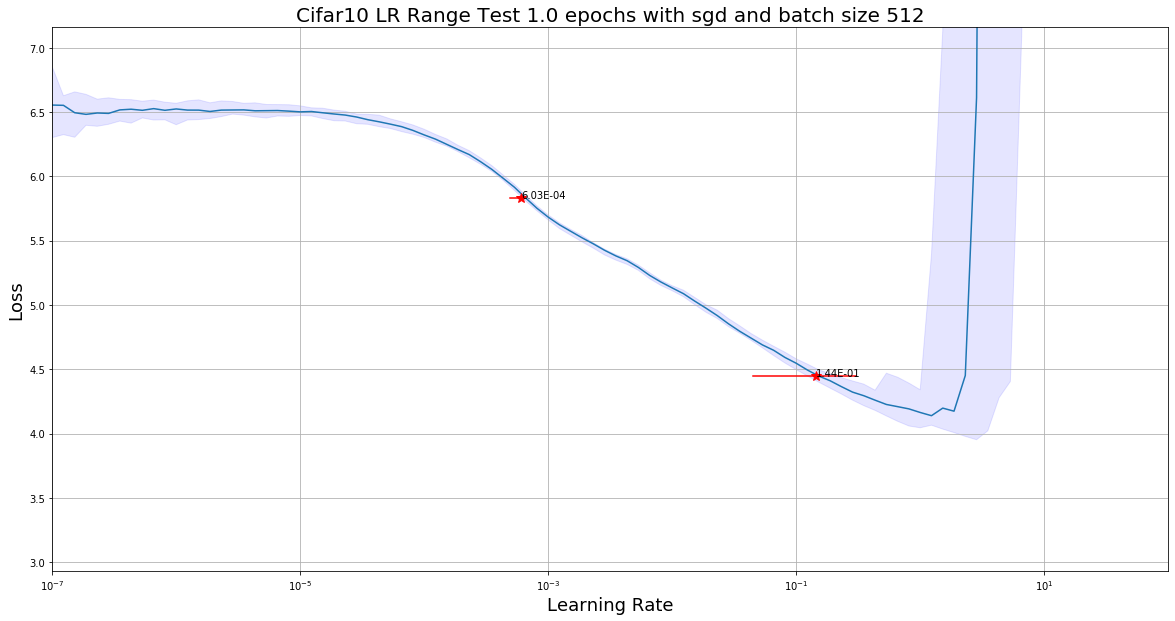

In [23]:
plot_lr_loss(lrs_res, all_losses_res, all_min_lr_res, all_max_lr_res, epoch_ratio="1.0", optimizer='sgd', bs=512, ylim_top_ratio=0.25)

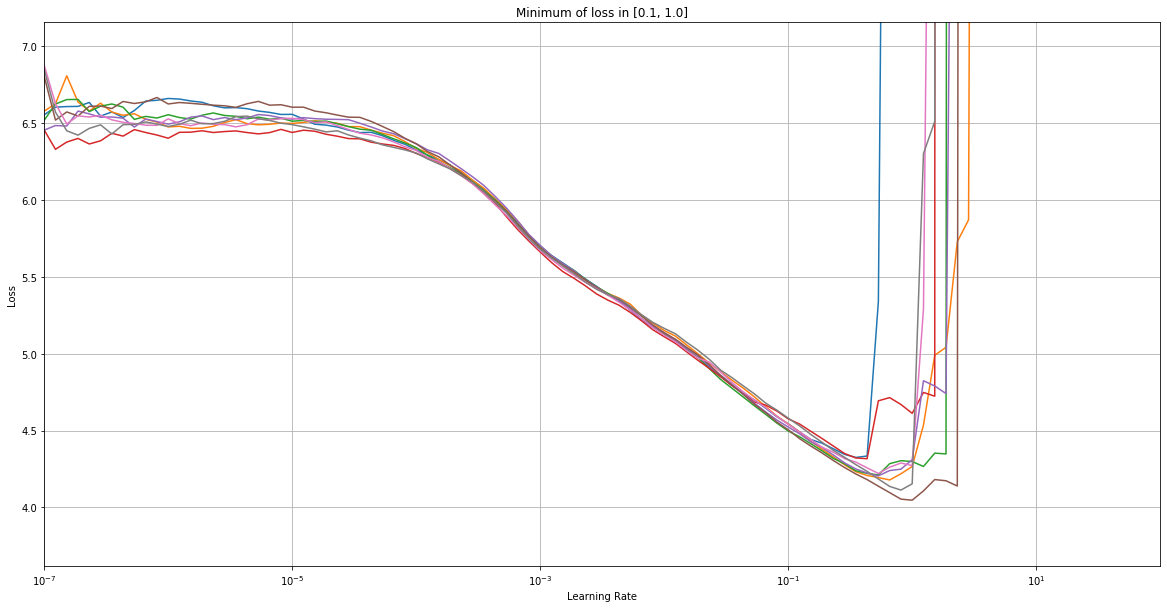

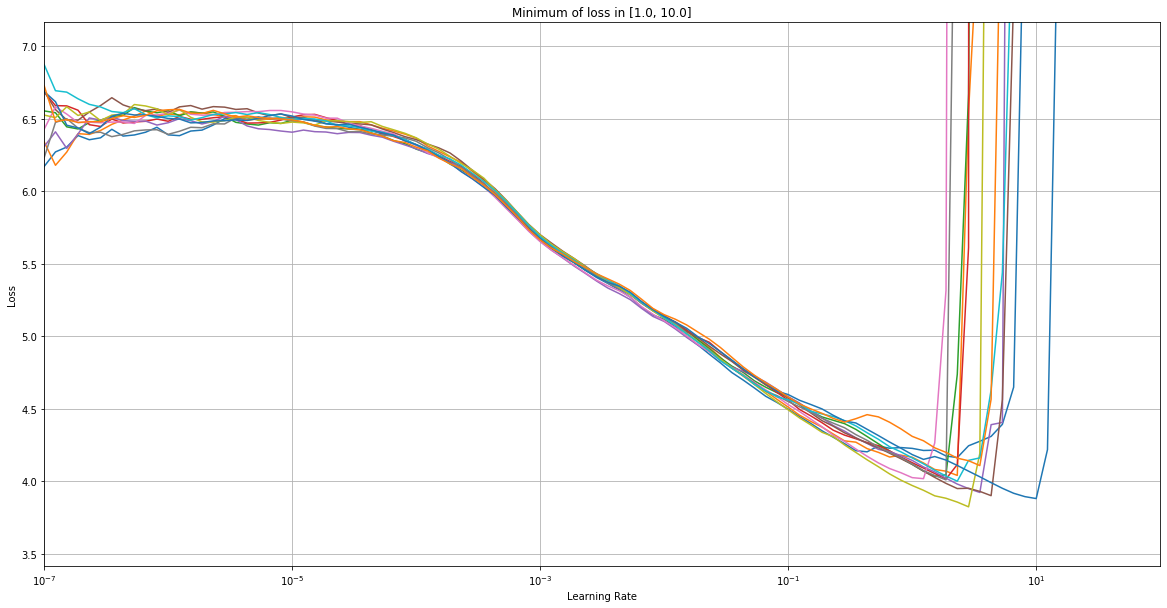

In [24]:
plot_lrrt_curves_by_max_lr(lrs_res, all_losses_res, all_max_lr_res)

### Multiple runs with different weight initialization and random batch sampling

In [ ]:
lrs_res, all_losses_res, all_min_lr_res, all_max_lr_res = multiple_runs_lr_find(
    n = NUM_EXPERIMENTS, 
    learn = False, 
    filepath = './lr_find_data_random_weight.pkl'
)

In [7]:
with open('./lr_find_data_random_weight.pkl', 'rb') as fp:
        lrs_res, all_losses_res, all_min_lr_res, all_max_lr_res = pickle.load(fp)

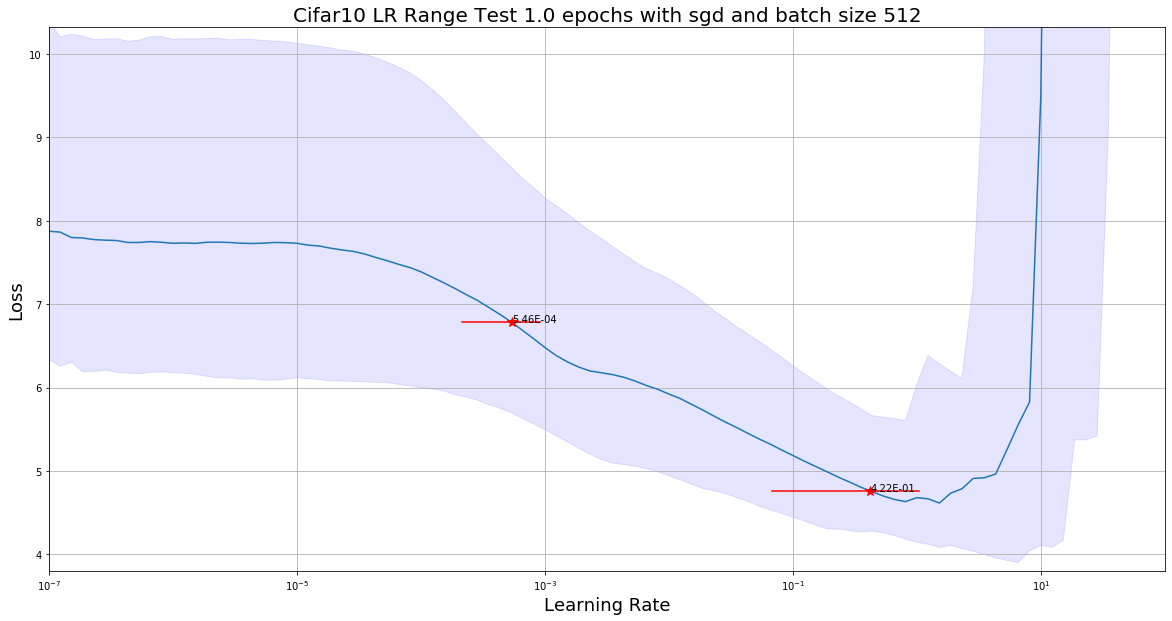

In [12]:
plot_lr_loss(lrs_res, all_losses_res, all_min_lr_res, all_max_lr_res, epoch_ratio="1.0", optimizer='sgd', bs=512)

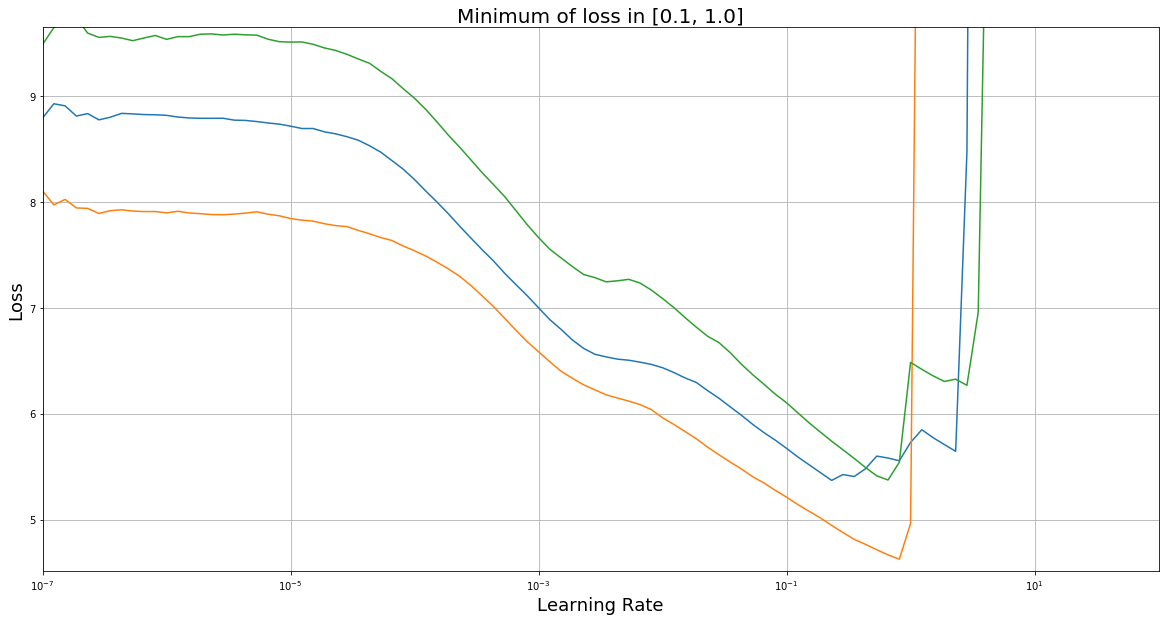

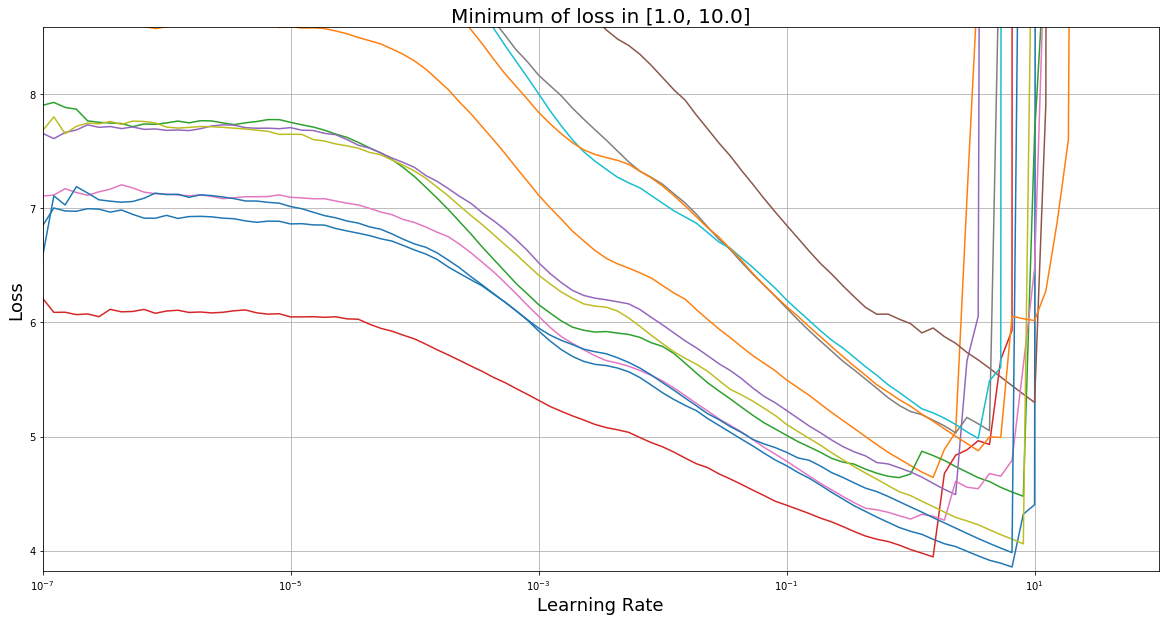

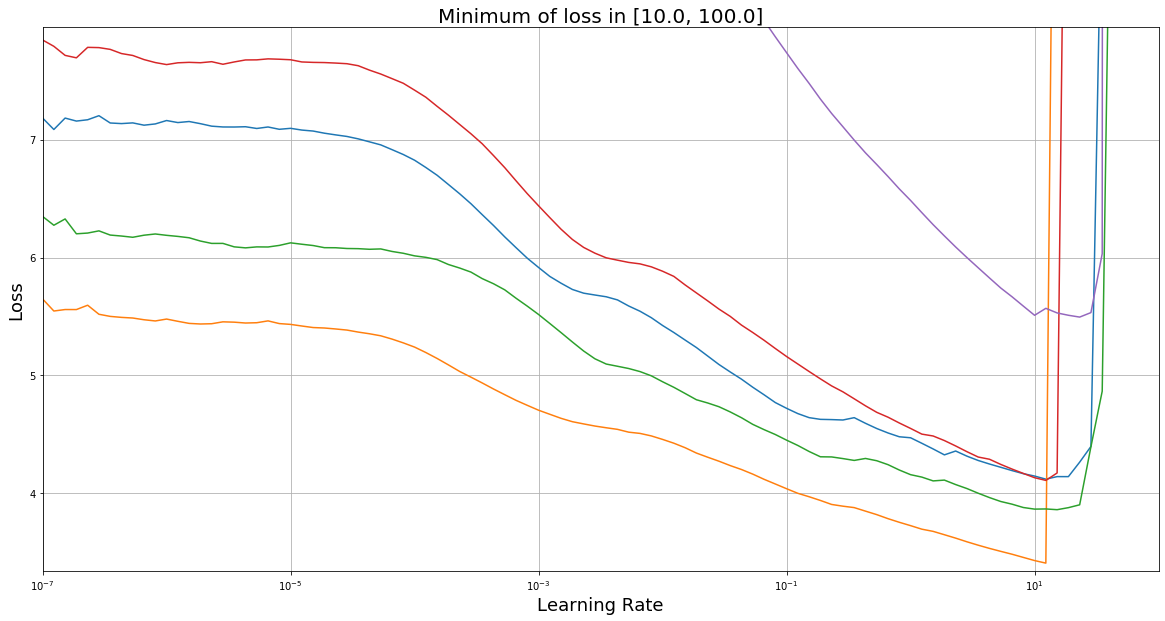

In [86]:
plot_lrrt_curves_by_max_lr(lrs_res, all_losses_res, all_max_lr_res)